### Import Libraries

In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from tqdm import tqdm
import logging
from Models import get_cifar10_model, get_cifar10_model2, get_cifar10_model3
from transforms import get_train_transforms, get_test_transforms, AlbumentationsDataset
from torchsummary import summary
import os
from tabulate import tabulate

### Configure the logger

In [2]:
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

In [3]:
# Initialize lists for tracking metrics
train_losses = []
test_losses = []
train_acc = []
test_acc = []

### Define the functions for Training and Testing

In [4]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        
        pbar.set_description(f'Loss={loss.item():0.4f} Accuracy={100*correct/processed:0.2f}%')
    
    epoch_accuracy = 100 * correct / processed
    train_acc.append(epoch_accuracy)
    logger.info(f'Train Epoch: {epoch} Accuracy: {epoch_accuracy:.2f}%')
    return epoch_accuracy

def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    accuracy = 100. * correct / len(test_loader.dataset)
    test_acc.append(accuracy)
    
    logger.info(f'Test Epoch: {epoch} Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return accuracy


### Function to plot the Training and Tests - Accuracy and losses

In [5]:
def plot_metrics():
    fig, axs = plt.subplots(2,2,figsize=(15, 10))
    axs[0, 0].plot([t.item() for t in train_losses])
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].set_title("Test Accuracy")
    plt.show()

### Download Dataset and Create Train/Test Split

In [6]:
# CIFAR10 mean and std
CIFAR_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR_STD = (0.2470, 0.2435, 0.2616)

# Download and load the data
logger.info("Downloading/Loading CIFAR10 dataset...")
# DATA_DIR = os.path.join(os.path.dirname(os.path.abspath(__file__)), 'data')
DATA_DIR = './data'
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

train_data = datasets.CIFAR10(DATA_DIR, train=True, download=True)
test_data = datasets.CIFAR10(DATA_DIR, train=False, download=True)
logger.info(f"Dataset loaded: {len(train_data)} training samples, {len(test_data)} test samples")

2024-12-19 16:09:56,063 - INFO - Downloading/Loading CIFAR10 dataset...


Files already downloaded and verified
Files already downloaded and verified


2024-12-19 16:09:58,075 - INFO - Dataset loaded: 50000 training samples, 10000 test samples


### Perform Data Transformations, Image augmentations

In [7]:
# Apply transforms
logger.info("Applying data transformations...")
train_transform = get_train_transforms(CIFAR_MEAN, CIFAR_STD)
test_transform = get_test_transforms(CIFAR_MEAN, CIFAR_STD)

train_dataset = AlbumentationsDataset(train_data, train_transform)
test_dataset = AlbumentationsDataset(test_data, test_transform)

2024-12-19 16:09:58,081 - INFO - Applying data transformations...


### Initialize Dataloader Arguments & Test/Train Dataloaders

In [8]:
# Best parameters based on the Optuna trial run

def get_best_training_params():
    """
    Returns a dictionary containing training parameters
    """
    params = {
        'batch_size': 256,
        'lr': 0.010437444157261664,
        'momentum': 0.8512255917793516,
        'weight_decay': 0.00011501504747675241,
        'max_lr': 0.29687976151495027,
        'pct_start': 0.23028556477512505,
        'div_factor': 15,
        'final_div_factor': 100
    }
    return params

In [9]:
# Get the best parameters
best_params = get_best_training_params()
EPOCHS = 200
BATCH_SIZE = best_params['batch_size']

# Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                                             shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, 
                                            shuffle=False, num_workers=2)
logger.info(f"Dataloaders created with batch size: {BATCH_SIZE}")

2024-12-19 16:09:58,104 - INFO - Dataloaders created with batch size: 256


### The Model and its parameters

### Model Summary

In [10]:
# Model, Optimizer and Scheduler setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

# model = get_cifar10_model2().to(device)
model = get_cifar10_model3().to(device)
logger.info("Model architecture:")
summary(model, (3, 32, 32))

# Calculate total steps correctly
total_steps = EPOCHS * len(train_loader)
    
optimizer = optim.SGD(model.parameters(), lr=best_params['lr'], momentum=best_params['momentum'], weight_decay=best_params['weight_decay'])
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=best_params['max_lr'],
    epochs=EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=best_params['pct_start'],
    div_factor=best_params['div_factor'],
    final_div_factor=best_params['final_div_factor'],
    anneal_strategy='cos'
)
logger.info("Optimizer and scheduler initialized")

2024-12-19 16:09:58,115 - INFO - Using device: cuda
2024-12-19 16:09:58,240 - INFO - Model architecture:
2024-12-19 16:09:58,677 - INFO - Optimizer and scheduler initialized


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 32, 32]             324
       BatchNorm2d-2           [-1, 12, 32, 32]              24
              ReLU-3           [-1, 12, 32, 32]               0
           Dropout-4           [-1, 12, 32, 32]               0
            Conv2d-5           [-1, 24, 32, 32]           2,592
       BatchNorm2d-6           [-1, 24, 32, 32]              48
              ReLU-7           [-1, 24, 32, 32]               0
           Dropout-8           [-1, 24, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           6,912
      BatchNorm2d-10           [-1, 32, 32, 32]              64
             ReLU-11           [-1, 32, 32, 32]               0
          Dropout-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 48, 32, 32]          13,824
      BatchNorm2d-14           [-1, 48,

### Let's Train and test our model

In [11]:
# Training loop
logger.info("Starting training...")

best_accuracy = 0

# Create headers for our metrics table
metrics_headers = ["Epoch", "Train Acc", "Test Acc", "Acc Diff", "Train Loss", "Test Loss"]
epoch_metrics = []

for epoch in range(1, EPOCHS + 1):
    logger.info(f"Epoch {epoch}/{EPOCHS}")
    train_accuracy = train(model, device, train_loader, optimizer, epoch)
    test_accuracy = test(model, device, test_loader, epoch)

    # Calculate average training loss for this epoch
    train_loss = sum(train_losses[-len(train_loader):]) / len(train_loader)
    test_loss = test_losses[-1]  # Latest test loss
        
    # Store metrics for this epoch
    epoch_metrics.append([
        epoch,
        f"{train_accuracy:.2f}%",
        f"{test_accuracy:.2f}%",
        f"{(train_accuracy - test_accuracy):.2f}%",
        f"{train_loss:.4f}",
        f"{test_loss:.4f}"
    ])
    
    if test_accuracy > best_accuracy:
       best_accuracy = test_accuracy
       logger.info(f"New best accuracy: {best_accuracy:.2f}%")

logger.info(f"Training completed. Best test accuracy: {best_accuracy:.2f}%")

2024-12-19 16:09:58,683 - INFO - Starting training...
2024-12-19 16:09:58,684 - INFO - Epoch 1/200
Loss=1.4918 Accuracy=28.43%: 100%|███████████████████████████████████████████████████| 196/196 [00:13<00:00, 14.34it/s]
2024-12-19 16:10:12,368 - INFO - Train Epoch: 1 Accuracy: 28.43%
2024-12-19 16:10:19,161 - INFO - Test Epoch: 1 Average loss: 1.5773, Accuracy: 40.92%
2024-12-19 16:10:19,175 - INFO - New best accuracy: 40.92%
2024-12-19 16:10:19,175 - INFO - Epoch 2/200
Loss=1.3523 Accuracy=44.03%: 100%|███████████████████████████████████████████████████| 196/196 [00:13<00:00, 15.05it/s]
2024-12-19 16:10:32,197 - INFO - Train Epoch: 2 Accuracy: 44.03%
2024-12-19 16:10:38,923 - INFO - Test Epoch: 2 Average loss: 1.4242, Accuracy: 49.99%
2024-12-19 16:10:38,939 - INFO - New best accuracy: 49.99%
2024-12-19 16:10:38,939 - INFO - Epoch 3/200
Loss=1.2840 Accuracy=49.46%: 100%|███████████████████████████████████████████████████| 196/196 [00:13<00:00, 14.92it/s]
2024-12-19 16:10:52,079 - INFO 

In [12]:
# Display metrics table
logger.info("Epoch-wise Training Summary:")
print("\n" + tabulate(epoch_metrics, headers=metrics_headers, tablefmt="grid"))

2024-12-19 17:17:31,994 - INFO - Epoch-wise Training Summary:



+---------+-------------+------------+------------+--------------+-------------+
|   Epoch | Train Acc   | Test Acc   | Acc Diff   |   Train Loss |   Test Loss |
+=========+=============+============+============+==============+=============+
|       1 | 28.43%      | 40.92%     | -12.49%    |       1.8642 |      1.5773 |
+---------+-------------+------------+------------+--------------+-------------+
|       2 | 44.03%      | 49.99%     | -5.96%     |       1.5042 |      1.4242 |
+---------+-------------+------------+------------+--------------+-------------+
|       3 | 49.46%      | 51.83%     | -2.37%     |       1.3704 |      1.3387 |
+---------+-------------+------------+------------+--------------+-------------+
|       4 | 53.87%      | 60.79%     | -6.92%     |       1.2605 |      1.0656 |
+---------+-------------+------------+------------+--------------+-------------+
|       5 | 56.88%      | 55.42%     | 1.46%      |       1.1907 |      1.3062 |
+---------+-------------+--

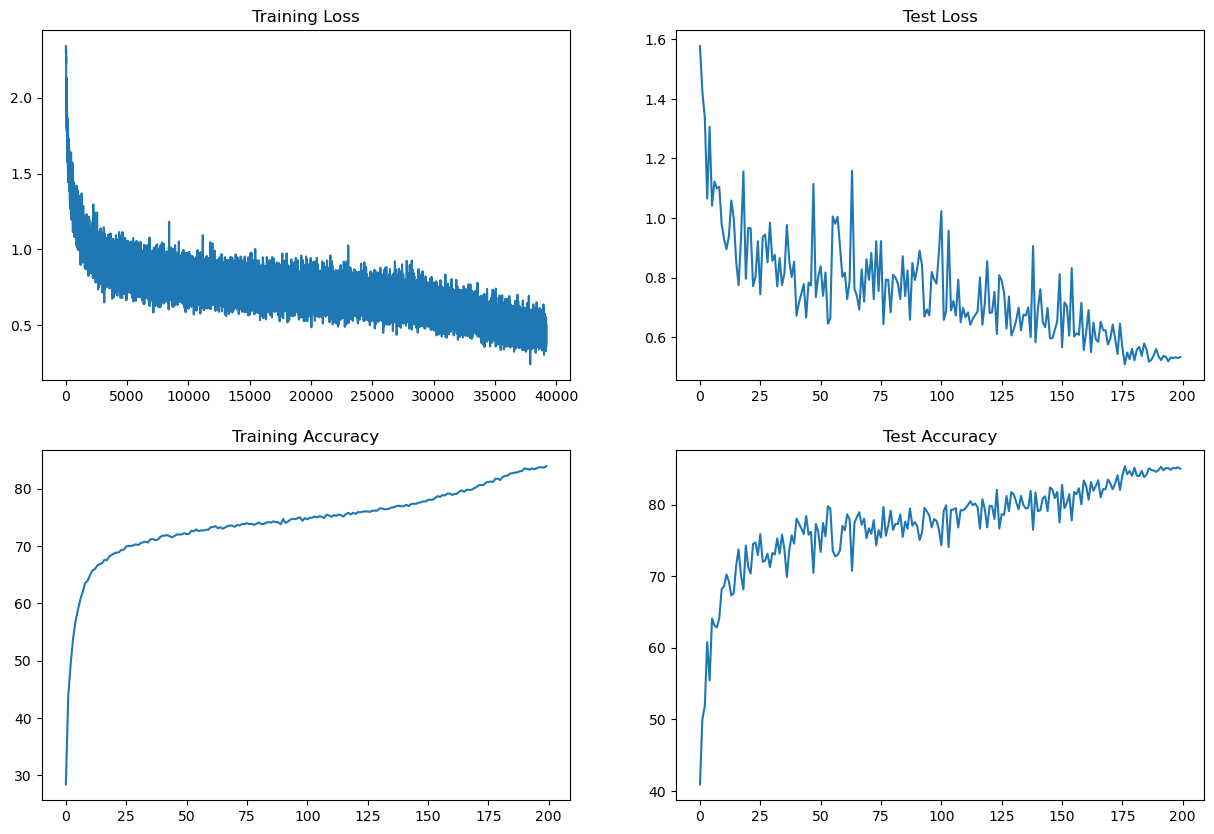

In [13]:
# Plot final metrics
plot_metrics()